In [1]:
import numpy as np
import matplotlib.pylab as plt
import model.user as usr
import model.satellite as sat
#from random import randrange
import random
from tqdm.autonotebook import tqdm
import model.neuralnetwork as NN

<ipython-input-1-4be668dd1b17>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Using TensorFlow backend.


In [2]:
# beam1 = sat.Beam()
# beam2 = sat.Beam()
beams = 2
# pd = [beams, 0, 1]
n_actions = 1 * beams + 1
n_state = 16 * (beams)
actions = np.ndarray((1, n_actions))
for i in range(n_actions):
    actions[0, i] = 1 

In [3]:
agent = NN.Agent(n_actions, actions, n_state, True, "")
#a = sat.Satellite(env)

In [4]:
def best_action(new_state):
    beam = np.random.randint(beams)
    if new_state[beam][0] > 0 and new_state[beam][1] < 10:
        action = beam
    else:
        action = beams
    
    return action

MR = []
# env = sat.Satellite(beams)
for i in tqdm(range(10)):
    env = sat.Satellite(beams)
    for j in range(400):
        if 0 == j:
            old_state = env.state()
        # if j % 10 == 0:
        #     action = best_action(old_state)
        # else:
        action = env.random_action()
        new_state, reward, done, info = env.step(action)
        
        if (done):
            new_state = env.advance()
        
        MR.append([old_state, action, new_state, reward])
        old_state = new_state

Widget Javascript not detected.  It may not be installed or enabled properly.


In [5]:
MR_actions = []
MR_in_service_0 = []
MR_in_service_1 = []
MR_in_wait_0 = []
MR_in_wait_1 = []
MR_reward = []
MR_visual_len = 1000
offset = 0
for i in range(MR_visual_len):
    i = i + offset
    MR_in_service_0.append(len(np.argwhere(np.array(MR[i][0][0][1:]) > -1)))
    # MR_in_service_0.append(MR[i][0][0][1])
    MR_in_wait_0.append(MR[i][0][0][0])
    MR_in_service_1.append(len(np.argwhere(np.array(MR[i][0][1][1:]) > -1)))
    # MR_in_service_1.append(MR[i][0][1][1])
    MR_in_wait_1.append(MR[i][0][1][0])
    MR_actions.append(MR[i][1])
    MR_reward.append(MR[i][3])
    i = i - offset

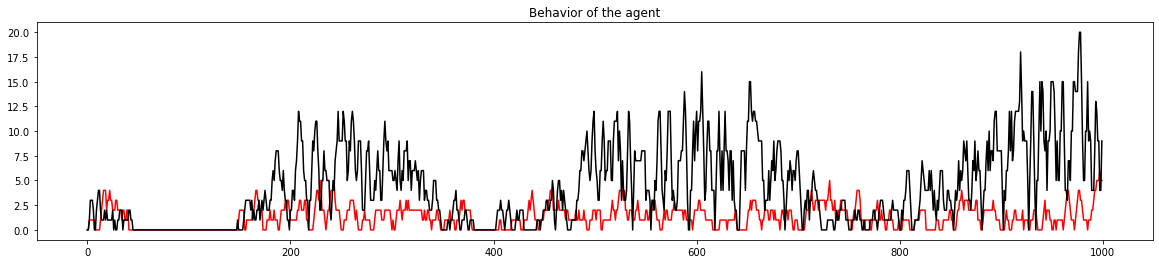

In [6]:
plt.figure(figsize=(20,4))
plt.plot(MR_in_service_0, color='red', label='Number of processing services ')
plt.plot(MR_in_wait_0, color='black', label='Wait to be served')
# plt.bar(np.arange(3600), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
#plt.legend()
plt.savefig('Results')
plt.show()

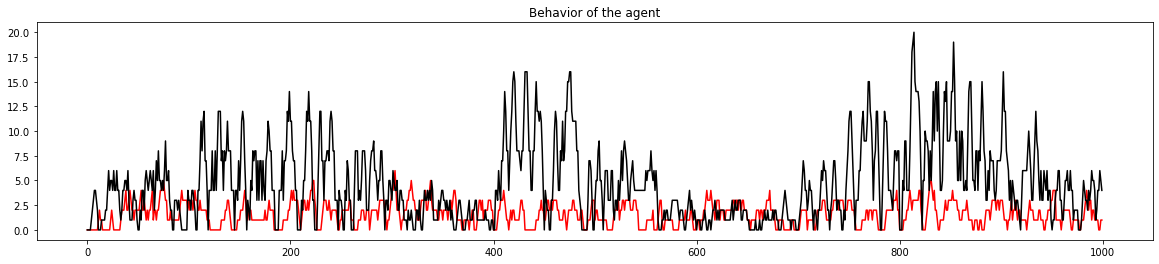

In [7]:
plt.figure(figsize=(20,4))
plt.plot(MR_in_service_1, color='red', label='Number of processing services ')
plt.plot(MR_in_wait_1, color='black', label='Wait to be served')
# plt.bar(np.arange(3600), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
#plt.legend()
plt.savefig('Results')
plt.show()

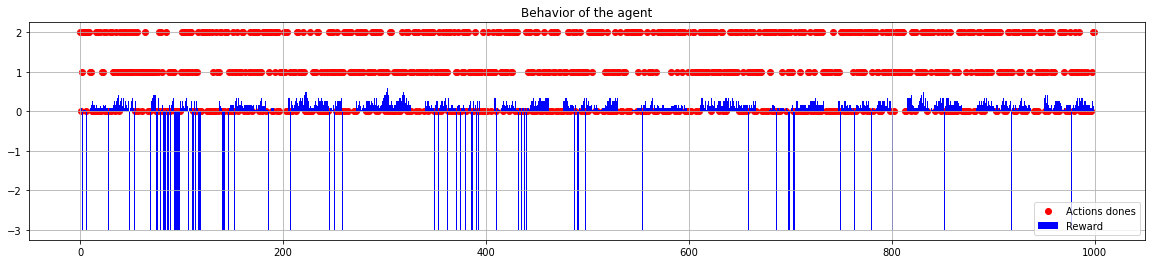

In [8]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(MR_visual_len), MR_actions, color='red', label='Actions dones')
plt.bar(np.arange(MR_visual_len), MR_reward, color='blue', label='Reward')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.show()
#MR_reward

In [9]:
# batch_size = 50
# random.sample(list(range(len(MR))), batch_size)
# MR[300]
# sample = np.random.randint(len(MR))
# print(sample)
#MR[sample]
print (MR)

[[array([[ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]]), 2, array([[ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]]), 0.0], [array([[ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]]), 0, array([[ 1.,  6., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]]), 0.08333333333333333], [array([[ 1.,  6., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        

In [10]:
#Training
number_episodes = 101#training episodes
steps = 500
training_step = 2 #interval between neural network trainings
batch_size = 3
update = 10
validation = 10
test_episodes = 10
simulation = []
training_rewards = []
penalties = np.zeros(test_episodes)
advance = 5
for episode in tqdm(range(number_episodes)):
    env = sat.Satellite(beams)
    for step in range(steps):
        if 0 == step:
            old_state = env.state()

        # Exploration vs exploitation
        prob = np.random.rand(1)
        if (prob < 1-(episode/number_episodes)):
            action = env.random_action()
            # if (step % 10 == 0):
            #     action = best_action(old_state)
        else:
            action, _ = agent.predict(old_state)
        
        # print(action)
        new_state, reward, done, info = env.step(action)
        MR.append([old_state, action, new_state, reward])
        old_state = new_state
            
        if (done):
            env.advance()

        if step % training_step == 0:
            samples=[]
            samples_indexes = random.sample(list(range(len(MR))), batch_size)
            for s_index in range(len(samples_indexes)):
                samples.append(MR[s_index])
            #samples_indexes = np.random.randint(len(MR) - batch_size)
            #for s_index in range(batch_size):
            #    samples.append(MR[s_index + samples_indexes])
            
            agent.train(samples)
        
        if step % update == 0:
            agent.update()
            
        if step % 2 == 0:
            MR.pop(0)

    if episode % validation == 0:
        REWARD = 0
        for m in range(test_episodes):
            env = sat.Satellite(beams)
            for n in range(steps):
                if n == 0:
                    old_state = env.state()
                action, q_values = agent.predict(old_state)
                new_state, reward, done, info = env.step(action)
                #print(reward)
                REWARD += reward
                if reward < 0:
                    penalties[m] += 1
                old_state = new_state
                if (done):
                    env.advance()
        REWARD = REWARD / (test_episodes * steps)
        training_rewards.append(REWARD)
        print (REWARD)
        
agent.save("model.h5")

Widget Javascript not detected.  It may not be installed or enabled properly.


-0.2825916666666659
-0.8290416666666397
-0.6298750000000028
-0.705749999999974
-0.6788666666666274
-0.6686166666666212
-0.6495916666666539
-0.30919166666669196
-0.3944666666666783
-0.8227583333333414
-0.5114999999999975



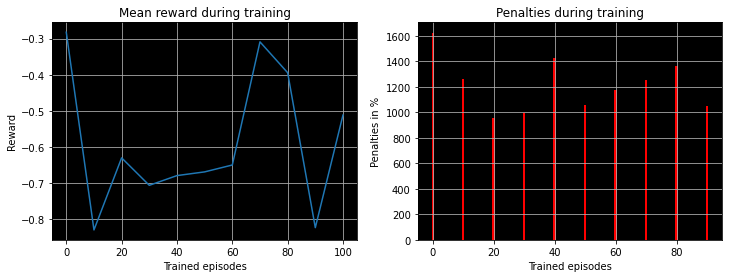

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(12,4))
axs[0].plot(np.arange(0, number_episodes, validation),training_rewards)
axs[0].set_title('Mean reward during training')
axs[0].set_xlabel('Trained episodes')
axs[0].set_ylabel('Reward')
axs[0].grid()
axs[0].set_facecolor('k')
axs[1].bar(np.arange(0, 100, 10), penalties, label='penalties', color='red')
axs[1].set_title('Penalties during training')
axs[1].set_xlabel('Trained episodes')
axs[1].set_ylabel('Penalties in %')
axs[1].grid()
axs[1].set_facecolor('k')
plt.show()

In [12]:
agent = NN.Agent(n_actions, actions, n_state, False, "model.h5")
simulation=[]
for m in range(1):
    env = sat.Satellite(beams)
    for n in range(3600):
        if n == 0:
            old_state = env.state()
        #action = env.random_action()
        action, q_value = agent.predict(old_state)
        new_state, reward, done, info = env.step(action)
        simulation.append([old_state, action, reward, done, q_value])
        if (done):  # or n % advance == 0):
            env.advance()
        old_state = new_state

In [13]:
# simulation
# q_value

In [14]:
actions = []
in_service_0 = []
in_service_1 = []
in_wait_0 = []
in_wait_1 = []
reward = []
q_values = []
stamps = 3600
for i in range(stamps):
    in_service_0.append(len(np.argwhere(np.array(simulation[i][0][0][1:]) > -1)))
    # in_service_0.append(simulation[i][0][0][1])
    in_wait_0.append(simulation[i][0][0][0])
    in_service_1.append(len(np.argwhere(np.array(simulation[i][0][1][1:]) > -1)))
    # in_service_1.append(simulation[i][0][1][1])
    in_wait_1.append(simulation[i][0][1][0])
    actions.append(simulation[i][1])
    reward.append(simulation[i][2])
    q_values.append(simulation[i][4])

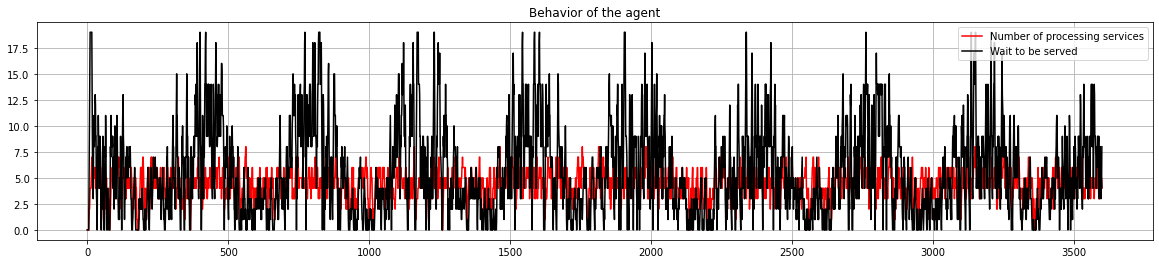

In [15]:
plt.figure(figsize=(20,4))
plt.plot(in_service_0, color='red', label='Number of processing services')
plt.plot(in_wait_0, color='black', label='Wait to be served')
# plt.bar(np.arange(stamps), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
#plt.xlim()
plt.show()

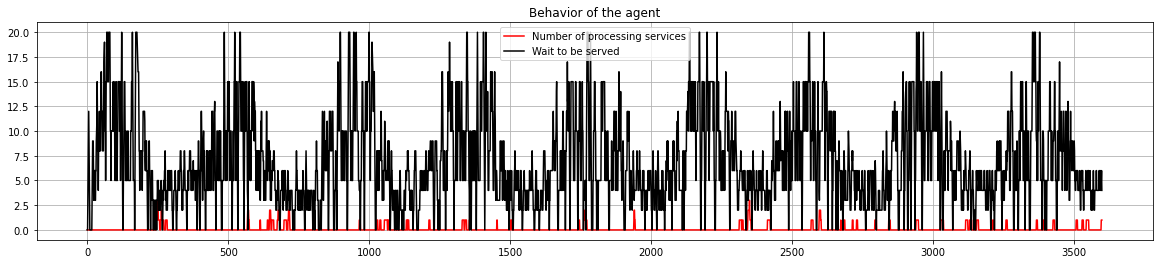

In [16]:
plt.figure(figsize=(20,4))
plt.plot(in_service_1, color='red', label='Number of processing services')
plt.plot(in_wait_1, color='black', label='Wait to be served')
# plt.bar(np.arange(stamps), reward, color='blue', label='Reward')
# plt.scatter(np.arange(3600), actions, color='yellow', label='Actions dones')
plt.title('Behavior of the agent')
plt.grid()
plt.legend()
plt.savefig('Results')
# plt.xlim([320, 330])
plt.show()

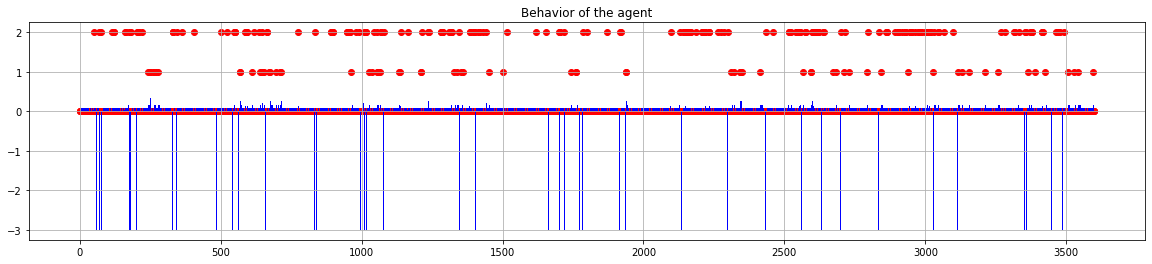

In [17]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(stamps), actions, color='red', label='Actions dones')
plt.bar(np.arange(stamps), reward, color='blue', label='Reward')
plt.title('Behavior of the agent')
plt.grid()
# plt.legend()
plt.savefig('Results')
# plt.xlim([320, 330])
plt.show()

In [18]:
# for i in range(len(simulation)):
#     print(simulation[i][0][0])
# print(old_state)
print(len(MR))
len(q_values[:])
q_values[0][0][1]

29250


array([-0.49257046], dtype=float32)

(0.0, 200.0)

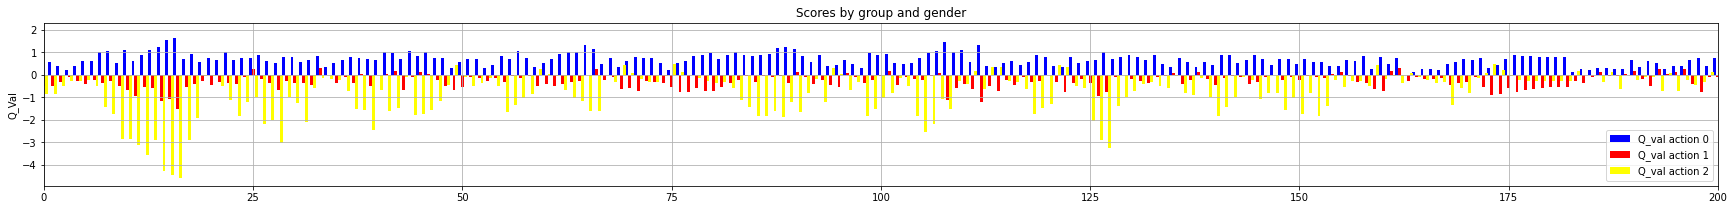

In [19]:
q_val_0 = []
q_val_1 = []
q_val_2 = []
# stamps = 100
for i in range(stamps):
    q_val_0.append(q_values[i][0][0][0])
    q_val_1.append(q_values[i][0][1][0])
    q_val_2.append(q_values[i][0][2][0])
    
#print(q_val_0)

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30,3))
ax.bar(np.arange(stamps) - width, q_val_0, width, color='blue', label='Q_val action 0')
ax.bar(np.arange(stamps), q_val_1, width, color='red', label='Q_val action 1')
ax.bar(np.arange(stamps) + width, q_val_2, width, color='yellow', label='Q_val action 2')
ax.set_ylabel('Q_Val')
ax.set_title('Scores by group and gender')
ax.grid()
ax.legend()
ax.set_xlim([0, 200])

start_point = start_point = np.random.uniform(0, 2*np.pi)
stamps = 400
mean = np.random.randint(3) + 2
x = np.linspace(start_point, 4 * np.pi + start_point, stamps)

arrival_rate = 2 * np.sin(x) + mean

ret = []
for i in range(len(arrival_rate)):
    ret.append(int(arrival_rate[i]))

plt.figure(figsize=(20,4))
plt.plot(ret, color='red', label='Number of processing services')
plt.title('Arrival rate')
plt.ylim([0, 5])
plt.grid()
plt.show()

MR[sample][0]